In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import chi2

from soma.tests.som import som_test, som_statistic

plt.style.use('seaborn')
plt.style.use('seaborn-paper')

In [56]:
# https://github.com/johnros/better_than_chance_code/blob/master/file2.Rmd

p = 23
n = 100
effects = np.linspace(0, 10, num=3)
sigma = np.identity(p)
sigma_inv = np.linalg.inv(sigma)

direction0 = np.ones(p)
mahalanobis = np.matmul(np.matmul(direction0, sigma_inv), direction0)
direction = direction0 / np.sqrt(n / 2 * mahalanobis)
replications = 100#0

def get_sample(effect):
    labels = np.repeat([0, 1], n//2)
    shift = np.full((n//2, p), fill_value=effect * direction)
    noise = np.random.normal(0, 1, size=(n, p))
    noise[labels==1] += shift
    return noise, labels

In [57]:
alpha = 0.05

rejects = np.zeros_like(effects)

for i in tqdm(range(len(rejects)), position=0):
    for _ in tqdm(range(replications), leave=True, position=1):
        samples, labels = get_sample(effects[i])
        pval = som_test(samples[labels==0], samples[labels==1], size=(5, 4))
        rejects[i] += pval <= alpha

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [58]:
rejects / replications

array([0.03, 0.1 , 0.49])

## Permutation

In [200]:
permutations = 1000
replications = 1#000

In [201]:
rejected = 0
for _ in tqdm(range(replications), position=1):
    samples, labels = get_sample(effects[2])
    t0, df = som_statistic(samples[labels==0], samples[labels==1], size=(5, 4), ret_df=True)

    permuted = np.zeros(permutations)
    for i in range(permutations):
        np.random.shuffle(labels)
        permuted[i] = som_statistic(samples[labels==0], samples[labels==1], size=(5, 4))[0]
    pval = np.mean(t0 < permuted)
    rejected += pval <= alpha

  0%|          | 0/1 [00:00<?, ?it/s]

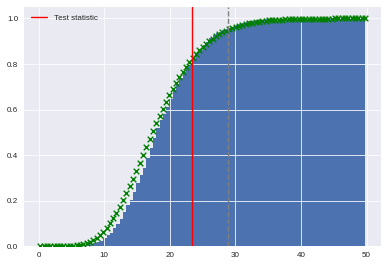

In [213]:
bins = np.linspace(0, 50, 100)
bins = (bins[:-1] + bins[1:])/2
plt.hist(permuted, density=True, bins=bins, zorder=-1, cumulative=True)
plt.scatter(bins, chi2.cdf(bins, df=df), marker='x', color='green')
plt.axvline(chi2.ppf(0.95, df=df), color='gray', linestyle='--')
plt.axvline(t0, color='red', label='Test statistic')
plt.legend()
plt.savefig('/home/aalvarez/Plots/chi2_hist.eps', bbox_inches='tight')
plt.show()

In [232]:
t0, np.mean(t0 < permuted) < alpha, df

(23.309523809523807, False, 18)

In [215]:
from scipy.stats import cramervonmises

In [227]:
cramervonmises(permuted, 'chi2', args=(19,))

CramerVonMisesResult(statistic=0.549557466999889, pvalue=0.029857515145667146)